In [ ]:
  !nvidia-smi

Tue Sep  1 13:07:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# 导入数据

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset=pd.read_csv('/content/drive/My Drive/air_inference/data/Bloomsbury_clean.csv')

In [ ]:
dataset.head()

,site,code,date,nox,no2,no,o3,pm2.5,ws,wd,air_temp
0,London Bloomsbury,CLL2,2018-01-01 00:00:00,38.719371,27.599582,7.252141,47.360318,7.497625,4.598855,257.279906,5.378717
1,London Bloomsbury,CLL2,2018-01-01 01:00:00,38.976582,27.836512,7.265368,47.042127,7.449653,4.603798,257.009139,5.412134
2,London Bloomsbury,CLL2,2018-01-01 02:00:00,39.251382,28.072885,7.290429,46.715825,7.416401,4.621557,256.762603,5.453970
3,London Bloomsbury,CLL2,2018-01-01 03:00:00,37.985254,27.997451,6.513879,46.400863,7.358787,4.636919,256.538550,5.502388
4,London Bloomsbury,CLL2,2018-01-01 04:00:00,38.973919,28.512513,6.822754,46.033610,7.302818,4.658491,256.342472,5.554477


# 多变量进行预测

In [ ]:
var_origin=dataset[['nox','no2','no','o3','pm2.5','ws','wd','air_temp']].values

数据进行归一化操作

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(var_origin)

将数据转为cuda类型

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
var= torch.FloatTensor(scaled).to(device)

划分训练集，验证集和测试集

In [ ]:
def splitData(var,per_val,per_test):
    num_val=int(len(var)*per_val)
    num_test=int(len(var)*per_test)
    train_size=int(len(var)-num_val-num_test)
    train_data=var[0:train_size]
    val_data=var[train_size:train_size+num_val]
    test_data=var[train_size+num_val:train_size+num_val+num_test]
    return train_data,val_data,test_data

我们的验证集合测试集都取10%

In [ ]:
train_data,val_data,test_data=splitData(var,0.1,0.1)

查看长度

In [ ]:
print('The length of train data, validation data and test data are:',len(train_data),',',len(val_data),',',len(test_data))

The length of train data, validation data and test data are: 14016 , 1752 , 1752



取一定大小的窗口进行滑动，每个窗口的label值是窗口下一个预测的第一个空气污染物的值

In [ ]:
train_window = 240
def create_train_sequence(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [ ]:
train_inout_seq = create_train_sequence(train_data, train_window)
print('The total number of train windows is',len(train_inout_seq))

The total number of train windows is 13776


注意，与上面创建train_data的sequence不同，验证集数据(实验是96个验证集数据)只是label。其数据部分还是需要借助于train集中的数据，大小为一个窗口。而这一个窗口的数据并不会在训练过程中被使用

In [ ]:
def create_val_sequence(train_data,val_data, tw):
    temp=torch.cat((train_data,val_data))   #先将训练集和测试集合并
    inout_seq = []
    L = len(val_data)
    for i in range(L):
        val_seq = temp[-(train_window+L)+i:-L+i]
        val_label = test_data[i:i+1]
        inout_seq.append((val_seq ,val_label))

    return inout_seq

val_inout_seq = create_val_sequence(train_data, val_data,train_window)
print('The total number of validation windows is',len(val_inout_seq))

The total number of validation windows is 1752


In [ ]:
val_inout_seq[0][1].shape

torch.Size([1, 8])

In [ ]:
def create_test_sequence(train_data,val_data,test_data, tw):
    temp=torch.cat((train_data,val_data))   #先将训练集和测试集合并
    temp=torch.cat((temp,test_data))
    inout_seq = []
    L = len(test_data)
    for i in range(L):
        test_seq = temp[-(train_window+L)+i:-L+i]
        test_label = test_data[i:i+1]
        inout_seq.append((test_seq ,test_label))

    return inout_seq

test_inout_seq = create_test_sequence(train_data, val_data, test_data,train_window)
print('The total number of validation windows is',len(val_inout_seq))

The total number of validation windows is 1752


# 定义LSTM

与单变量lstm不同的是，这次的数据的维度为8维，而单变量只有1维

In [ ]:
train_data.shape

torch.Size([14016, 8])

In [ ]:
from torch import nn
import torch.nn.init as init
import torch.nn.functional as F
class LSTM(nn.Module):
    def __init__(self,input_size=8,hidden_layer_size=50,output_size=1,num_layers=1):
        super().__init__()
        self.hidden_layer_size=hidden_layer_size
        self.lstm=nn.LSTM(input_size,hidden_layer_size,num_layers,bidirectional=True)
        self.linear1=nn.Linear(hidden_layer_size,hidden_layer_size)
        self.linear2=nn.Linear(hidden_layer_size,output_size)
        self.hidden_cell=(torch.zeros(num_layers*2,1,self.hidden_layer_size),torch.zeros(num_layers*2,1,self.hidden_layer_size))
        init_rnn(self.lstm,'xavier')
        
    def forward(self,input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.reshape(len(input_seq),1,8), self.hidden_cell)
        out=self.linear1(lstm_out.view(len(input_seq)*2, -1))
        out=torch.tanh(out)
        predictions = self.linear2(out)
        return predictions[-1]


#设定初始化
def init_rnn(x, type='uniform'):
    for layer in x._all_weights:
        for w in layer:
            if 'weight' in w:
                if type == 'xavier':
                    init.xavier_normal_(getattr(x, w))
                elif type == 'uniform':
                    stdv = 1.0 / math.sqrt(x.hidden_size)
                    init.uniform_(getattr(x, w), -stdv, stdv)
                elif type == 'normal':
                    stdv = 1.0 / math.sqrt(x.hidden_size)
                    init.normal_(getattr(x, w), .0, stdv)
                else:
                    raise ValueError


# 训练模型

在训练模型我们需要了解到，该实验是变量预测单变量，根据单变量数量进行多次预测。。。比方说，我们现在有8个attributes,用来预测1个attribute(比如nox)。。。刚开始我是准备8个attributes预测8个attributes，但是实验结果真的是太差了，还不如单变量预测单变量。。。

In [ ]:
import copy

epochs=5


#为了实现多变量预测多个单变量，我这里用了五个LSTM模型
model_nox=LSTM().to(device)
model_no2=LSTM().to(device)
model_no=LSTM().to(device)
model_o3=LSTM().to(device)
model_pm25=LSTM().to(device)

loss_function=nn.MSELoss()
optimizer_nox = torch.optim.SGD(model_nox.parameters(), lr=0.03,momentum=0.2, weight_decay=6e-4)
optimizer_no2 = torch.optim.SGD(model_no2.parameters(), lr=0.03,momentum=0.4, weight_decay=6e-4)
optimizer_no = torch.optim.SGD(model_no.parameters(), lr=0.03,momentum=0.4, weight_decay=6e-4)
optimizer_o3 = torch.optim.SGD(model_o3.parameters(), lr=0.01,momentum=0.2, weight_decay=6e-4)
optimizer_pm25 = torch.optim.SGD(model_pm25.parameters(), lr=0.03,momentum=0.2, weight_decay=6e-4)

attr_dic={
    'nox':model_nox,
    'no2':model_no2,
    'no':model_no,
    'o3':model_o3,
    'pm2.5':model_pm25
}

index_dic={
    'nox':0,
    'no2':1,
    'no':2,
    'o3':3,
    'pm2.5':4
    
}

optimizer_dic={
    'nox':optimizer_nox,
    'no2':optimizer_no2,
    'no':optimizer_no,
    'o3':optimizer_o3,
    'pm2.5':optimizer_pm25
}

loss_train_dic={
    'nox':[],
    'no2':[],
    'no':[],
    'o3':[],
    'pm2.5':[]
}

loss_val_dic={
    'nox':[],
    'no2':[],
    'no':[],
    'o3':[],
    'pm2.5':[]
}

value_train_dic={
    'nox':[],
    'no2':[],
    'no':[],
    'o3':[],
    'pm2.5':[]
}

value_val_dic={
    'nox':[],
    'no2':[],
    'no':[],
    'o3':[],
    'pm2.5':[]
}


In [ ]:
def train_model(attr,model):
  model.train()
  print('训练',attr,'模型')
  for i in range(epochs):
    #train
    add=0
    for seq,label in train_inout_seq:   
        optimizer_dic[attr].zero_grad()
        seq=seq.to(device)
        label=label.to(device)
        model.hidden_cell = (torch.zeros(2, 1, model.hidden_layer_size).to(device),torch.zeros(2, 1, model.hidden_layer_size).to(device))
        y_pred = model(seq)

        if(i==epochs-1):  #对最后一次epoch的值进行记录
          value_train_dic[attr].append(y_pred)

        single_loss = loss_function(y_pred[0], label[0,index_dic[attr]])   #这里只预测label[i]的数值，即某个单一的空气污染物
        add+=single_loss
        single_loss .backward()
        optimizer_dic[attr].step()
    loss_train=add/len(train_inout_seq)
    loss_train_dic[attr].append(loss_train)


    #val
    add=0 
    t=0

    val_inputs=train_data[-train_window:]
    fut_pred = len(val_data)

    for seq,label in val_inout_seq:
      with torch.no_grad():
        seq = val_inputs[-train_window:].to(device)
        label=label.to(device)
        y_pred=model(seq)
        single_loss=loss_function(y_pred[0],label[0,index_dic[attr]])  

        add+=single_loss

        if(i==epochs):  #对最后一次epoch的值进行记录
          value_val_dic[attr].append(y_pred)

        temp=copy.deepcopy(val_data[t])
        temp[index_dic[attr]]=y_pred
        temp=temp.view(1,-1)
        
        val_inputs=torch.cat((val_inputs,temp),0)
        t+=0

    loss_val=add/len(val_inout_seq)
    loss_val_dic[attr].append(loss_val)

    print(f'epoch: {i:3}  train_loss:{loss_train:10.8f} val_loss:{loss_val:10.8f}')
  print('----------------------')

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def test_model(attr,model):
  temp=torch.cat((train_data,val_data))
  test_inputs=temp[-train_window:,:]

  fut_pred = len(test_data)
  test_list=[]
  test_results=copy.deepcopy(test_data)

  model.eval()

  for i in range(fut_pred):
      seq = test_inputs[-train_window:].to(device)
      with torch.no_grad():
          model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                          torch.zeros(1, 1, model.hidden_layer_size))
          y_pred=model(seq)
          temp=copy.deepcopy(test_data[i]).view(1,-1)
          # temp[index_dic[attr]]=y_pred
          # temp=temp.view(1,-1)
          test_inputs=torch.cat((test_inputs,temp),0)
          test_results[i]=y_pred




  actual_predictions = scaler.inverse_transform(np.array(test_results.cpu()))




  x = np.arange(len(train_data)+len(val_data), len(dataset), 1)
  plt.figure(figsize=(8, 6))
  plt.grid(True)

  plt.plot(dataset.loc[len(dataset)-len(test_data):,attr].values,color="red",label='real value')
  plt.plot(actual_predictions[:,index_dic[attr]],label='prediction')

  plt.title('hours vs '+attr)
  plt.ylabel(attr)
  plt.xlabel('hour')

  plt.legend(loc='upper right',fontsize=15)

  y_true=dataset.loc[len(dataset)-len(test_data):,attr].values
  y_pred=actual_predictions[:,index_dic[attr]]
  print('mse: ',mean_squared_error(y_true, y_pred))
  print('mae: ',mean_absolute_error(y_true, y_pred))

In [ ]:
def predict_future(attr,model):
  temp=torch.cat((train_data,val_data))
  test_inputs=temp[-train_window:,:]

  fut_pred = 96
  test_list=[]
  test_results=copy.deepcopy(test_data)

  model.eval()

  for i in range(fut_pred):
      seq = test_inputs[-train_window:].to(device)
      with torch.no_grad():
          model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                          torch.zeros(1, 1, model.hidden_layer_size))
          y_pred=model(seq)
          temp=copy.deepcopy(test_data[i])
          temp[index_dic[attr]]=y_pred
          temp=temp.view(1,-1)
          test_inputs=torch.cat((test_inputs,temp),0)
          test_results[i]=y_pred




  actual_predictions = scaler.inverse_transform(np.array(test_results.cpu()))





  plt.figure(figsize=(8, 6))
  plt.grid(True)

  plt.plot(dataset.loc[len(dataset)-len(test_data):len(dataset)-len(test_data)+fut_pred,attr].values,color="red",label='real value')
  plt.plot(actual_predictions[:fut_pred,index_dic[attr]],label='prediction')

  plt.title('hours vs '+attr)
  plt.ylabel(attr)
  plt.xlabel('hour')

  plt.legend(loc='upper right',fontsize=15)

  y_true=dataset.loc[len(dataset)-len(test_data):len(dataset)-len(test_data)+fut_pred-1,attr].values
  y_pred=actual_predictions[:fut_pred,index_dic[attr]]

  print('mse: ',mean_squared_error(y_true, y_pred))
  print('mae: ',mean_absolute_error(y_true, y_pred))

  y_pred=pd.DataFrame(y_pred)

  y_pred.to_csv('/content/drive/My Drive/air_inference/result24/bilstm'+attr+'.csv',index=False)

In [ ]:
train_model('nox',model_nox)

训练 nox 模型
epoch:   0  train_loss:0.00101271 val_loss:0.05859372
epoch:   1  train_loss:0.00122110 val_loss:0.05827784
epoch:   2  train_loss:0.00139540 val_loss:0.05807886
epoch:   3  train_loss:0.00151246 val_loss:0.05784544
epoch:   4  train_loss:0.00159955 val_loss:0.05759565
----------------------


mse:  2750.163879221245
mae:  45.8778982739422


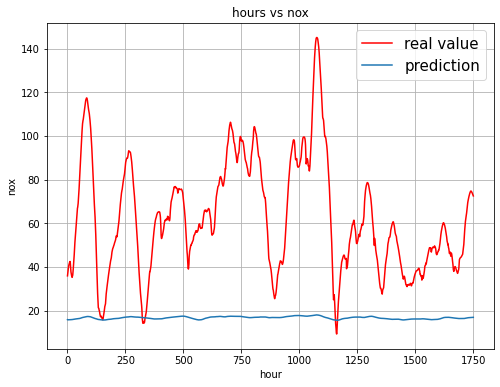

In [ ]:
test_model('nox',model_nox)

mse:  4441.970272025831
mae:  59.18444957769022


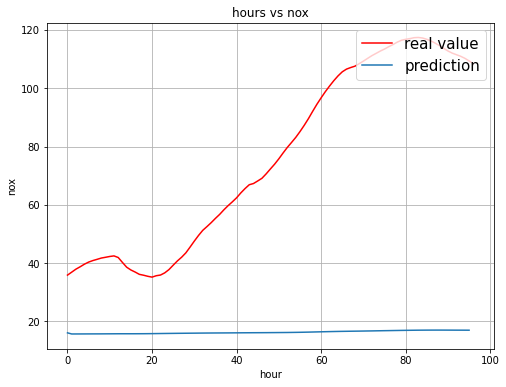

In [ ]:
predict_future('nox',model_nox)

In [ ]:
train_model('no2',model_no2)

训练 no2 模型


KeyboardInterrupt: ignored

In [ ]:
test_model('no2',model_no2)

In [ ]:
predict_future('no2',model_no2)

In [ ]:
train_model('no',model_no)

In [ ]:
test_model('no',model_no)

In [ ]:
predict_future('no',model_no)

In [ ]:
train_model('o3',model_o3)

In [ ]:
test_model('o3',model_o3)

In [ ]:
predict_future('o3',model_o3)

In [ ]:
train_model('pm2.5',model_pm25)

In [ ]:
test_model('pm2.5',model_pm25)

In [ ]:
predict_future('pm2.5',model_pm25)